# Exploratory data analysis
In this notebook, we will perform an extensive exploratory data analysis (EDA) in order to get more insight into the data. This will be useful for more elaborate preprocessing.

### Table of contents
* [Load data](#load)
* [First data inspection](#inspection)
* [Faulty data](#faulty)
* [Missing data](#missing)
* [Categorical variables](#categorical)
* [Distributions](#distributions)
* [Relationship between features](#featurerelation)
* [Relationship with target](#targetrelation)
* [Outliers](#outliers)
* [Clusters](#clusters)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import probplot, chi2, chi2_contingency, f_oneway
from typing import Dict, List, Any, Set, Optional, Tuple, Union

# display full dataframes:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

train_data_file = "../data/train.csv"
target_col = "SalePrice"

## Load data <a class="anchor"  id="load"></a>
To prevent any biased decisions, the EDA is performed only on the training set. Thus, only the training data is loaded.

In [2]:
train_df = pd.read_csv(train_data_file)
train_df.set_index("Id", inplace=True)
y_train = train_df[target_col]
X_train = train_df.drop(columns=[target_col])

cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

## First data inspection <a class="anchor"  id="inspection"></a>
**Questions: What is the size of data? What does the data look like? What are the variable data types?**

In [3]:
print(f"Size of training data: {train_df.shape}")

Size of training data: (1460, 80)


In [4]:
train_df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
603,60,RL,80.0,10041,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,789,Unf,0,119,908,GasA,Ex,Y,SBrkr,927,988,0,1915,1,0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1992.0,Fin,2,506,TA,TA,Y,120,150,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,220000
996,50,RL,51.0,4712,Pave,NaN,IR1,Lvl,AllPub,Inside,Mod,BrkSide,Feedr,Norm,1Fam,1.5Fin,4,7,1946,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,384,Unf,0,363,747,GasA,TA,Y,SBrkr,774,456,0,1230,1,0,1,1,3,1,TA,5,Typ,0,NaN,Detchd,1946.0,Unf,1,305,TA,TA,Y,0,57,0,0,63,0,NaN,MnPrv,NaN,0,8,2006,WD,Abnorml,121600
1243,85,RL,85.0,10625,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,SFoyer,7,6,1974,1974,Gable,CompShg,Plywood,Plywood,BrkFace,81.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,885,LwQ,168,0,1053,GasA,TA,Y,SBrkr,1173,0,0,1173,1,0,2,0,3,1,Gd,6,Typ,2,TA,Attchd,1974.0,RFn,2,528,TA,TA,Y,0,120,0,0,0,0,NaN,MnPrv,NaN,0,1,2010,WD,Family,170000
466,120,RM,NaN,3072,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2004,2004,Hip,CompShg,VinylSd,VinylSd,BrkFace,18.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1375,1375,GasA,Ex,Y,SBrkr,1414,0,0,1414,0,0,2,0,2,1,Gd,6,Typ,1,TA,Attchd,2004.0,Fin,2,398,TA,TA,Y,144,20,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,178740
892,60,RL,70.0,11184,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,2Story,6,5,1978,1978,Hip,CompShg,HdBoard,HdBoard,BrkFace,92.0,TA,TA,CBlock,TA,TA,No,LwQ,226,Rec,500,192,918,GasA,Gd,Y,SBrkr,918,765,0,1683,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1978.0,RFn,2,440,TA,TA,Y,243,0,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal,172500


In [5]:
# distribution of data types:
X_train.dtypes.value_counts()

object     43
int64      33
float64     3
Name: count, dtype: int64

In [6]:
print(f"Data type of target: {y_train.dtype}")

Data type of target: int64


### Findings
The training data has 1460 rows and 80 columns. One of these columns is the target. Consequently, there are 79 feature columns where 43 are categorical, 33 integers and 3 floating point numbers. The target is represented as integer.

## Missing data <a class="anchor"  id="missing"></a>
**Questions: How is missing data represented? How much data is missing? Do missing values actually mean a specific value?**

In [7]:
# check for other representations of missing values than np.nan:
other_nan_rerpresentations = [
    "?",
    "-",
    "",
    " ",
    "None",
    None,
    "nan",
    "NAN",
    "n/a",
    "na",
    "NA",
    "null",
    "NULL",
    "nil",
    "NIL",
    "empty",
]
other_nan_rep_present = X_train.isin(other_nan_rerpresentations).any().any()
print(
    "Is there any other representation for missing values than np.nan?"
    f" {other_nan_rep_present}"
)

Is there any other representation for missing values than np.nan? False


In [8]:
# count missing values:
sum_missing = X_train.isna().sum().sort_values(ascending=False)
sum_missing[sum_missing > 0.0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

Looking into the data description, I make the following findings: For the following features, a missing value means that the feature is not available: Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature

### Findings
- All missing values seem to be represented by `np.nan`. 
- There are 19 columns with missing values in the training set. The features with the most missing values are PoolQC, MiscFeature, Alley, Fence, MasVnrType, FireplaceQu and LotFrontage. 
- For all features with missing values except for LotFrontage, GarageYrBlt, MasVnrArea & Electrical, it is stated in the data description that a missing value means that the feature is not available. 
- I assume that for the numerical features (LotFrontage, GarageYrBlt, MasVnrArea), the data description omits to state the meaning of missing values but that it means the same, that is, the corresponding feature is missing. 
- As for the one missing value in the categorical feature named Electrical, I think, this is a truely missing value with no special meaning.
- The categorical features concerning a garage (GarageCond, GarageType, GarageYrBlt, GarageQual, GarageFinish) have the same amount of missing values and thus, are coherent. However, the categorical features concerning a basement (BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual) differ by 1 missing value. So, here is something wrong with the data. This will be checked in the section [Faulty data](#faulty).

### Handling missing values
For some of the next steps of the EDA, the missing data should already be handled.
- For the categorical features Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature, missing values can be replaced by some unique string like "None" for example.
- For the numerical features LotFrontage and MasVnrArea that are measuring a size, a reasonable replacement of missing values would be their lower bound zero.
- For GarageYrBlt (numerical) it is more difficult since it is not measuring a size and has basically no lower bound. One sensible way to handle the corresponding missing values is to set them to some unique constant that is different from all other values this feature takes. Since no garage was built in year zero, this constant can be zero.
- The row with the single missing value of Electrical can be deleted as a whole since it is only one row.

In [9]:
# handling the missing values:
nan_string = "None"
nan_to_string = [
    "Alley",
    "MasVnrType",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "Fence",
    "MiscFeature",
]
nan_to_zero = ["LotFrontage", "MasVnrArea", "GarageYrBlt"]
nan_delete_row = ["Electrical"]

X_train_no_nan = X_train.copy()
X_train_no_nan[nan_to_string] = X_train_no_nan[nan_to_string].fillna(nan_string)
X_train_no_nan[nan_to_zero] = X_train_no_nan[nan_to_zero].fillna(0)
X_train_no_nan.dropna(axis=0, subset=nan_delete_row, inplace=True)
# delete the same rows in y_train:
y_train_no_nan = y_train.loc[X_train_no_nan.index]

## Faulty data <a class="anchor"  id="faulty"></a>
**Questions: Are there duplicated rows or columns? Does the feature’s data type make sense? Is a numerical feature actually categorical or vice versa? Do all values of one feature have the same data type? Are all values in the expected range? If multiple features are connected, is there any inconsistency?**

### Duplicates
There are no duplicated columns but 2 pairs of duplicated rows. However, in both cases, one duplicate is in the train data and the other in the test data. This may be done on purpose when the data split was performed and is most probably leading to a better predictive performance. So, I won't remove this data from the training set.

In [10]:
print(f"Are there any duplicated rows? {X_train.duplicated().any()}")
print(f"Are there any duplicated columns? {X_train.transpose().duplicated().any()}")

Are there any duplicated rows? False
Are there any duplicated columns? False


### Data types

In [11]:
# original data types of all the columns:
train_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


Looking into the data description, I make the following findings:
- MSSubClass is represented as integer but should be a categorical that has no order. Convert this to string data type.
- OverallQual, OverallCond are represented as integer but are actually ordered categoricals (string). Since the integers are already a good encoding, they don't need to be changed.
- LotArea, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, SalePrice are represented as integers but are actually continuous. Convert these to float data type.
- GarageYrBlt is represented as float but is actually integer. Convert this to integer (only possible after handling missing data because otherwise, it contains np.nan values).

In [12]:
def is_datatype_consistent_in_column(df: pd.DataFrame, col: str) -> bool:
    is_consistent = (df[col].map(type) == df[col].map(type).iloc[0]).all()
    return is_consistent


consistent_cols = []
inconsistent_cols = []
# note: use data with handled missing data because np.nan is always float
for col in X_train_no_nan.columns:
    is_consistent = is_datatype_consistent_in_column(df=X_train_no_nan, col=col)
    if is_consistent:
        consistent_cols.append(col)
    else:
        inconsistent_cols.append(col)
print(
    f"Columns with consistent data types: {consistent_cols}\nColumns with inconsistent"
    f" data types: {inconsistent_cols}"
)

Columns with consistent data types: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'Scre

### Value range

In [13]:
# note: use data with handled missing data because it introcudes a new category
X_train_no_nan.describe(include=["object"])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459
unique,5,2,3,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,5,5,5,7,7,6,5,2,5,4,7,6,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,None,None,WD,Normal
freq,1150,1453,1368,924,1310,1458,1051,1381,225,1259,1444,1219,726,1140,1433,514,503,871,905,1281,646,649,1310,952,429,1255,1427,741,1364,1334,735,1359,689,870,605,1310,1325,1339,1452,1178,1405,1266,1197


In [14]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


Comparing the data description with the range (min and max) for numerical features and with the number of unique values for categorical values, I make the following findings:
- The value ranges of all numerical features seem to be reasonable. For example, there are no negative values for size variables.
- OverallCond only takes 9 out of 10 values since the maximum of 10 is never reached.
- MSZoning only takes 5 out of 7 possible values. Utilities only takes 2 out of 4 possible values. Condition2 only takes 8 out of 9 possible values. Exterior1st only takes 15 out of 17 possible values. Exterior2nd only takes 16 out of 17 possible values. MasVnrType only takes 4 out of 5 values. ExterQual only takes 4 out of 5 possible values. BsmtQual & BsmtCond only takes 5 out of 6 values. KitchenQual only takes 4 out of 5 possible values. Functional only takes 7 out of 8 possible values. PoolQC only takes 4 out of 5 possible values. MiscFeature only takes 5 out of 6 possible values. SaleType only takes 9 out of 10 possible values.

### Inconsistency of related features

Looking into the data description, I find the following related features:
- Feature that are related via the condition whether a specific attribute exists:
    - MasVnrType, MasVnrArea
    - BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath
    - Fireplaces, FireplaceQu
    - GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond
    - PoolArea, PoolQC
    - MiscFeature, MiscVal
- Features connected by a timeline:
    - YearBuilt, YearRemodAdd, YrSold
- Multiple features of the same kind:
    - Condition1, Condition2
    - Exterior1st, Exterior2nd
- Features holding shared information:
    - MSSubClass, BldgType, HouseStyle, YearBuilt

#### Features related via condition whether an attribute exists

In [15]:
def get_inconsistent_indexes_of_related_columns(
    df: pd.DataFrame,
    direct_relations: Dict[Any, List[str]],
    implied_relations: Optional[Dict[Any, List[str]]] = None,
) -> Set[int]:
    # 1) direct relations:
    # if one of the direct related cols has its expected value, then all must have their
    # expected value
    # - determine involved indexes:
    direct_rel_indexes = []
    # direct relations:
    for expected_value, cols in direct_relations.items():
        for col in cols:
            direct_rel_indexes.append(set(df[df[col] == expected_value].index))
    # - determine inconsistent indexes:
    direct_rel_union = set().union(*direct_rel_indexes)
    direct_rel_intersection = direct_rel_indexes[0].intersection(
        *direct_rel_indexes[1:]
    )
    inconsistent_indexes = direct_rel_union.difference(direct_rel_intersection)

    # 2) implied relations:
    # if one of the direct related cols has its expected value, then all implied cols
    # must have their expected value
    # - determine involved indexes:
    if implied_relations:
        implied_rel_indexes = []
        for expected_value, cols in implied_relations.items():
            for col in cols:
                implied_rel_indexes.append(set(df[df[col] == expected_value].index))
        # - determine inconsistent indexes:
        implied_rel_differences = [
            direct_rel_intersection - s for s in implied_rel_indexes
        ]
        inconsistent_implied_rel_indexes = set().union(*implied_rel_differences)
        inconsistent_indexes = inconsistent_indexes.union(
            inconsistent_implied_rel_indexes
        )

    return inconsistent_indexes

In [16]:
# note: use data with handled missing data because its representation is used here
inconsistent_indexes_masvnr = get_inconsistent_indexes_of_related_columns(
    df=X_train_no_nan, direct_relations={nan_string: ["MasVnrType"], 0: ["MasVnrArea"]}
)
print(
    "Incosistent indexes for the masonry veneer features:"
    f" {inconsistent_indexes_masvnr}"
)

inconsistent_indexes_bsmt = get_inconsistent_indexes_of_related_columns(
    df=X_train_no_nan,
    direct_relations={
        nan_string: [
            "BsmtQual",
            "BsmtCond",
            "BsmtExposure",
            "BsmtFinType1",
        ],
        0: ["TotalBsmtSF"],
    },
    implied_relations={
        0: ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"],
        nan_string: ["BsmtFinType2"],
    },
)
print(f"Incosistent indexes for the basement features: {inconsistent_indexes_bsmt}")

inconsistent_indexes_fire = get_inconsistent_indexes_of_related_columns(
    df=X_train_no_nan, direct_relations={nan_string: ["FireplaceQu"], 0: ["Fireplaces"]}
)
print(f"Incosistent indexes for the fireplace features: {inconsistent_indexes_fire}")

inconsistent_indexes_garage = get_inconsistent_indexes_of_related_columns(
    df=X_train_no_nan,
    direct_relations={
        nan_string: ["GarageType", "GarageFinish", "GarageQual", "GarageCond"],
        0: ["GarageCars", "GarageArea"],
    },
)
print(f"Incosistent indexes for the garage features: {inconsistent_indexes_garage}")

inconsistent_indexes_pool = get_inconsistent_indexes_of_related_columns(
    df=X_train_no_nan, direct_relations={nan_string: ["PoolQC"], 0: ["PoolArea"]}
)
print(f"Incosistent indexes for the pool features: {inconsistent_indexes_pool}")

inconsistent_indexes_misc = get_inconsistent_indexes_of_related_columns(
    df=X_train_no_nan, direct_relations={nan_string: ["MiscFeature"], 0: ["MiscVal"]}
)
print(
    f"Incosistent indexes for the miscellaneous features: {inconsistent_indexes_misc}"
)

Incosistent indexes for the masonry veneer features: {774, 1231, 625, 689, 1301, 1335, 1242}
Incosistent indexes for the basement features: {949}
Incosistent indexes for the fireplace features: set()
Incosistent indexes for the garage features: set()
Incosistent indexes for the pool features: set()
Incosistent indexes for the miscellaneous features: {1201, 874}


In [17]:
# check out some inconsistent rows:
X_train_no_nan.loc[
    list(inconsistent_indexes_bsmt),
    [
        "BsmtQual",
        "BsmtCond",
        "BsmtExposure",
        "BsmtFinType1",
        "BsmtFinSF1",
        "BsmtFinType2",
        "BsmtFinSF2",
        "BsmtUnfSF",
        "TotalBsmtSF",
        "BsmtFullBath",
        "BsmtHalfBath",
    ],
]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
949,Gd,TA,None,Unf,0,Unf,0,936,936,0,0


#### Features connected by a timeline

In [18]:
def get_inconsistent_indexes_for_timeline(
    df: pd.DataFrame, timeline: List[str]
) -> Set[int]:
    inconsistent_indexes = set()
    for i in range(len(timeline) - 1):
        inconsistent_indexes = inconsistent_indexes.union(
            set(df.loc[df[timeline[i]] > df[timeline[i + 1]]].index)
        )
    return inconsistent_indexes


inconsistent_indexes_time = get_inconsistent_indexes_for_timeline(
    df=X_train, timeline=["YearBuilt", "YearRemodAdd", "YrSold"]
)
X_train.loc[list(inconsistent_indexes_time), ["YearBuilt", "YearRemodAdd", "YrSold"]]

,YearBuilt,YearRemodAdd,YrSold
Id,,,
524,2007,2008,2007


#### Features holding shared information:

In [19]:
# add column containing the string information of MSSubclass:
# note: I use the same terms as contained in HouseStyle and BldgType
MSSubClass_mapping = {
    20: "1Story 1946+",
    30: "1Story 1945-",
    40: "1Story FINISHED ATTIC",
    45: "1.5Unf",
    50: "1.5Fin",
    60: "2Story 1946+",
    70: "2Story 1945-",
    75: "2.5Fin OR 2.5Unf",
    80: "SLvl OR MULTI-LEVEL",
    85: "SFoyer",
    90: "Duplex",
    120: "1Story PUD 1946+",
    150: "1.5Story PUD",
    160: "2Story PUD 1946+",
    180: "PUD MULTILEVEL INCL SLvl SFoyer",
    190: "2fmCon",
}
X_train["MSSubClass_str"] = X_train["MSSubClass"].map(MSSubClass_mapping)
X_train_no_nan["MSSubClass_str"] = X_train_no_nan["MSSubClass"].map(MSSubClass_mapping)

In [20]:
def check_inconsistency(
    row: pd.Series, comprising_col: str, cols_values: Dict[str, List[str]]
) -> bool:
    comprising_value = row[comprising_col]
    for col, unique_values in cols_values.items():
        col_value = row[col]
        if any(value in comprising_value for value in unique_values) and (
            col_value not in comprising_value
        ):
            return False
    return True


is_consistent = X_train.apply(
    lambda row: check_inconsistency(
        row,
        comprising_col="MSSubClass_str",
        cols_values={
            "BldgType": list(X_train["BldgType"].unique()),
            "HouseStyle": list(X_train["HouseStyle"].unique()),
        },
    ),
    axis=1,
)
inconsistent_indexes_mssubclass = list(is_consistent.index[~is_consistent])
inconsistent_indexes_mssubclass

[75, 80, 198, 544, 608, 730, 945, 1440, 1441, 1444, 1449]

In [21]:
# check out the inconsistent rows:
X_train.loc[
    inconsistent_indexes_mssubclass, ["MSSubClass_str", "BldgType", "HouseStyle"]
]

,MSSubClass_str,BldgType,HouseStyle
Id,,,
75,1.5Fin,1Fam,2Story
80,1.5Fin,1Fam,2Story
198,2.5Fin OR 2.5Unf,1Fam,2Story
544,1Story PUD 1946+,TwnhsE,SFoyer
608,1Story 1946+,1Fam,2Story
730,1Story 1945-,1Fam,1.5Fin
945,1Story 1946+,1Fam,SLvl
1440,2Story 1946+,1Fam,SLvl
1441,2Story 1945-,1Fam,2.5Fin


#### Multiple features of the same kind:

In [22]:
# note: if condition2 is normal, I expect condition1 also to be normal
X_train.loc[
    (X_train["Condition2"] != "Norm") & (X_train["Condition1"] == "Norm"),
    ["Condition1", "Condition2"],
]

# note: for exterior1st and exterior2nd, I don't have any special rule since they are just equal if there is only one exterior material

,Condition1,Condition2
Id,,


### Findings
- There are no duplicated rows or columns in the training data.
- All columns have a consistent data type. That is, all values in a column have the same type.
- For some columns, the data type should be changed (see above).
- The value ranges of the numerical features seem to be correct. 
- There are 15 (pseudo-)categorical features that never take on 1-2 of the possible values. If the test data will have these values, those data example will be harder to predict.
- There are 10 inconsistent rows concerning the existence of a masonry veneer, basement ans miscellaneous feature:
    - For the one inconsistent basement row, I guess that the column BsmtExposure should be corrected to "No" for "no exposure" instead of "None" for "no basement". Then the row would be consistent.
    - For the remaining inconsistent rows, I cannot guess what would be an appropriate correction since there are only 2 rows involved.
- There is 1 inconsistent row concerning the timeline where the house is remodeled after being sold. Although this is a possible situation, it is a kind of data leakage since the information of the remodeling is available only after the target is determined.
- There are 11 inconsistent rows concerning the MSSubClass.
- Side note: The only relevant information that MSSubClass adds is whether 
    - the attic of a 1Story house is finished
    - the house is a PUD
- Altogether there are 22 inconsistent rows in the training data. This is roughly 1.5%.

## Categorical variables <a class="anchor"  id="categorical"></a>
**Questions: Is there an ordering in the categories? Are there special characters (non ASCII)?**

According to the data description, I expect the following classification into ordered and unordered categorical features:
- **No order**: MSSubClass (note: originally numerical), MSZoning, Street, Alley, LandContour, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, GarageType, MiscFeature, SaleType, SaleCondition
- **With order**: LotShape, Utilities, LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence

In [23]:
# note: use data with handled missing data because np.nan is always float
non_ascii_present = (
    X_train_no_nan.select_dtypes(include="object")
    .applymap(lambda text: not text.isascii())
    .any()
    .any()
)
print(
    "Are there any non-ASCII characters contained in the training set?"
    f" {non_ascii_present}"
)

Are there any non-ASCII characters contained in the training set? False


### Findings
- There are 24 unordered and 20 ordered categorical features (see above).
- There are no non-ASCII characters in the training set.

## Distributions <a class="anchor"  id="distributions"></a>
**Questions: Are there inf values? Is the feature continuous or discrete? If discrete: How many distinct values are there? Is the distribution similar to a normal distribution? Is the distribution skewed? Are there particularly rare or frequent values sticking out? Do the features have a similar range? Are the assumptions of the ML algorithm you want to use met?**

In [24]:
inf_present = train_df.select_dtypes(exclude="object").applymap(np.isinf).any().any()
print(f"Are there any inf values contained in the training set? {inf_present}")

Are there any inf values contained in the training set? False


### Features

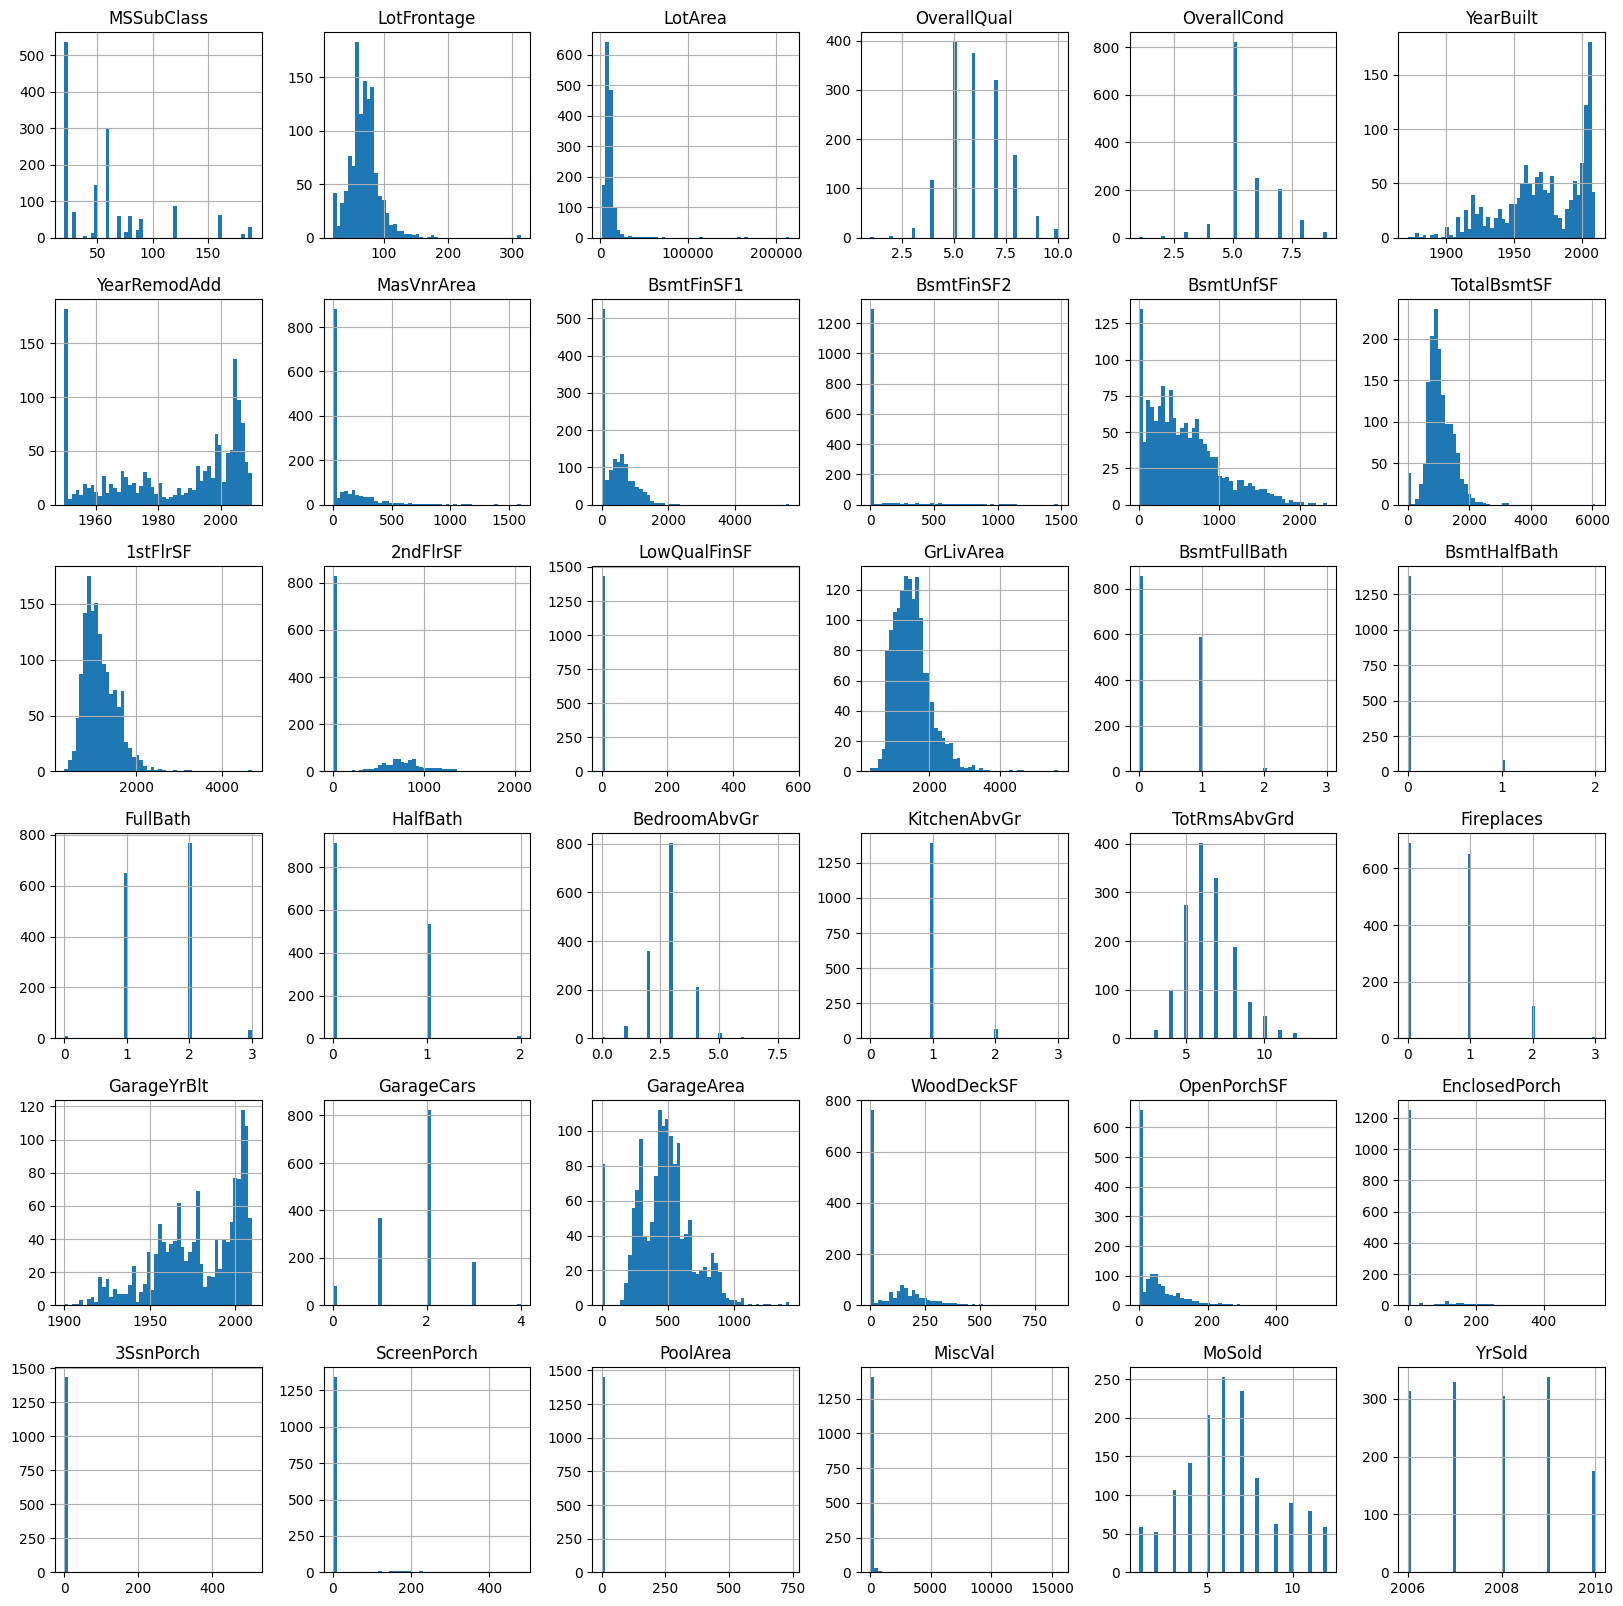

In [25]:
# histograms for numerical features:
X_train.hist(figsize=(20, 20), bins=50)
plt.show()

Findings for the numerical features:
- In the section [Faulty data](#faulty), some numerical features were identified as truely integer and some as truely floating point. This conincides with the classification into discrete (integer) and continuous (float) features since there are no floating point features that have by definition only a countable number of values.
- Most of the distributions seem to be far-off from a normal distribution.
- For the following features, there is one very frequent lower bound value that is sticking out of the distribution: LotFrontage, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 2ndFlrSF, LowQualFinSF, GarageArea, WoodDeckSF, OpenPorchSF, EbclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal. Except for YearRemodAdd where this value is 1950, the lower bound value is always 0. The zero-values are here explained by the fact that the corresponding feature is not existing. For the YearRemodAdd feature, I am not sure whether I can trust this data since it seems to be unlikey that most houses have been remodeled in 1950 but not before.
- Most of the size/area features have very rare high values.
- The numerical features differ greatly in their range. LotArea ranges beyond 200k while most discrete features stay below 10. For machine learning algorithms that are sensitive to scale, a feature scaling is therefore mandatory.

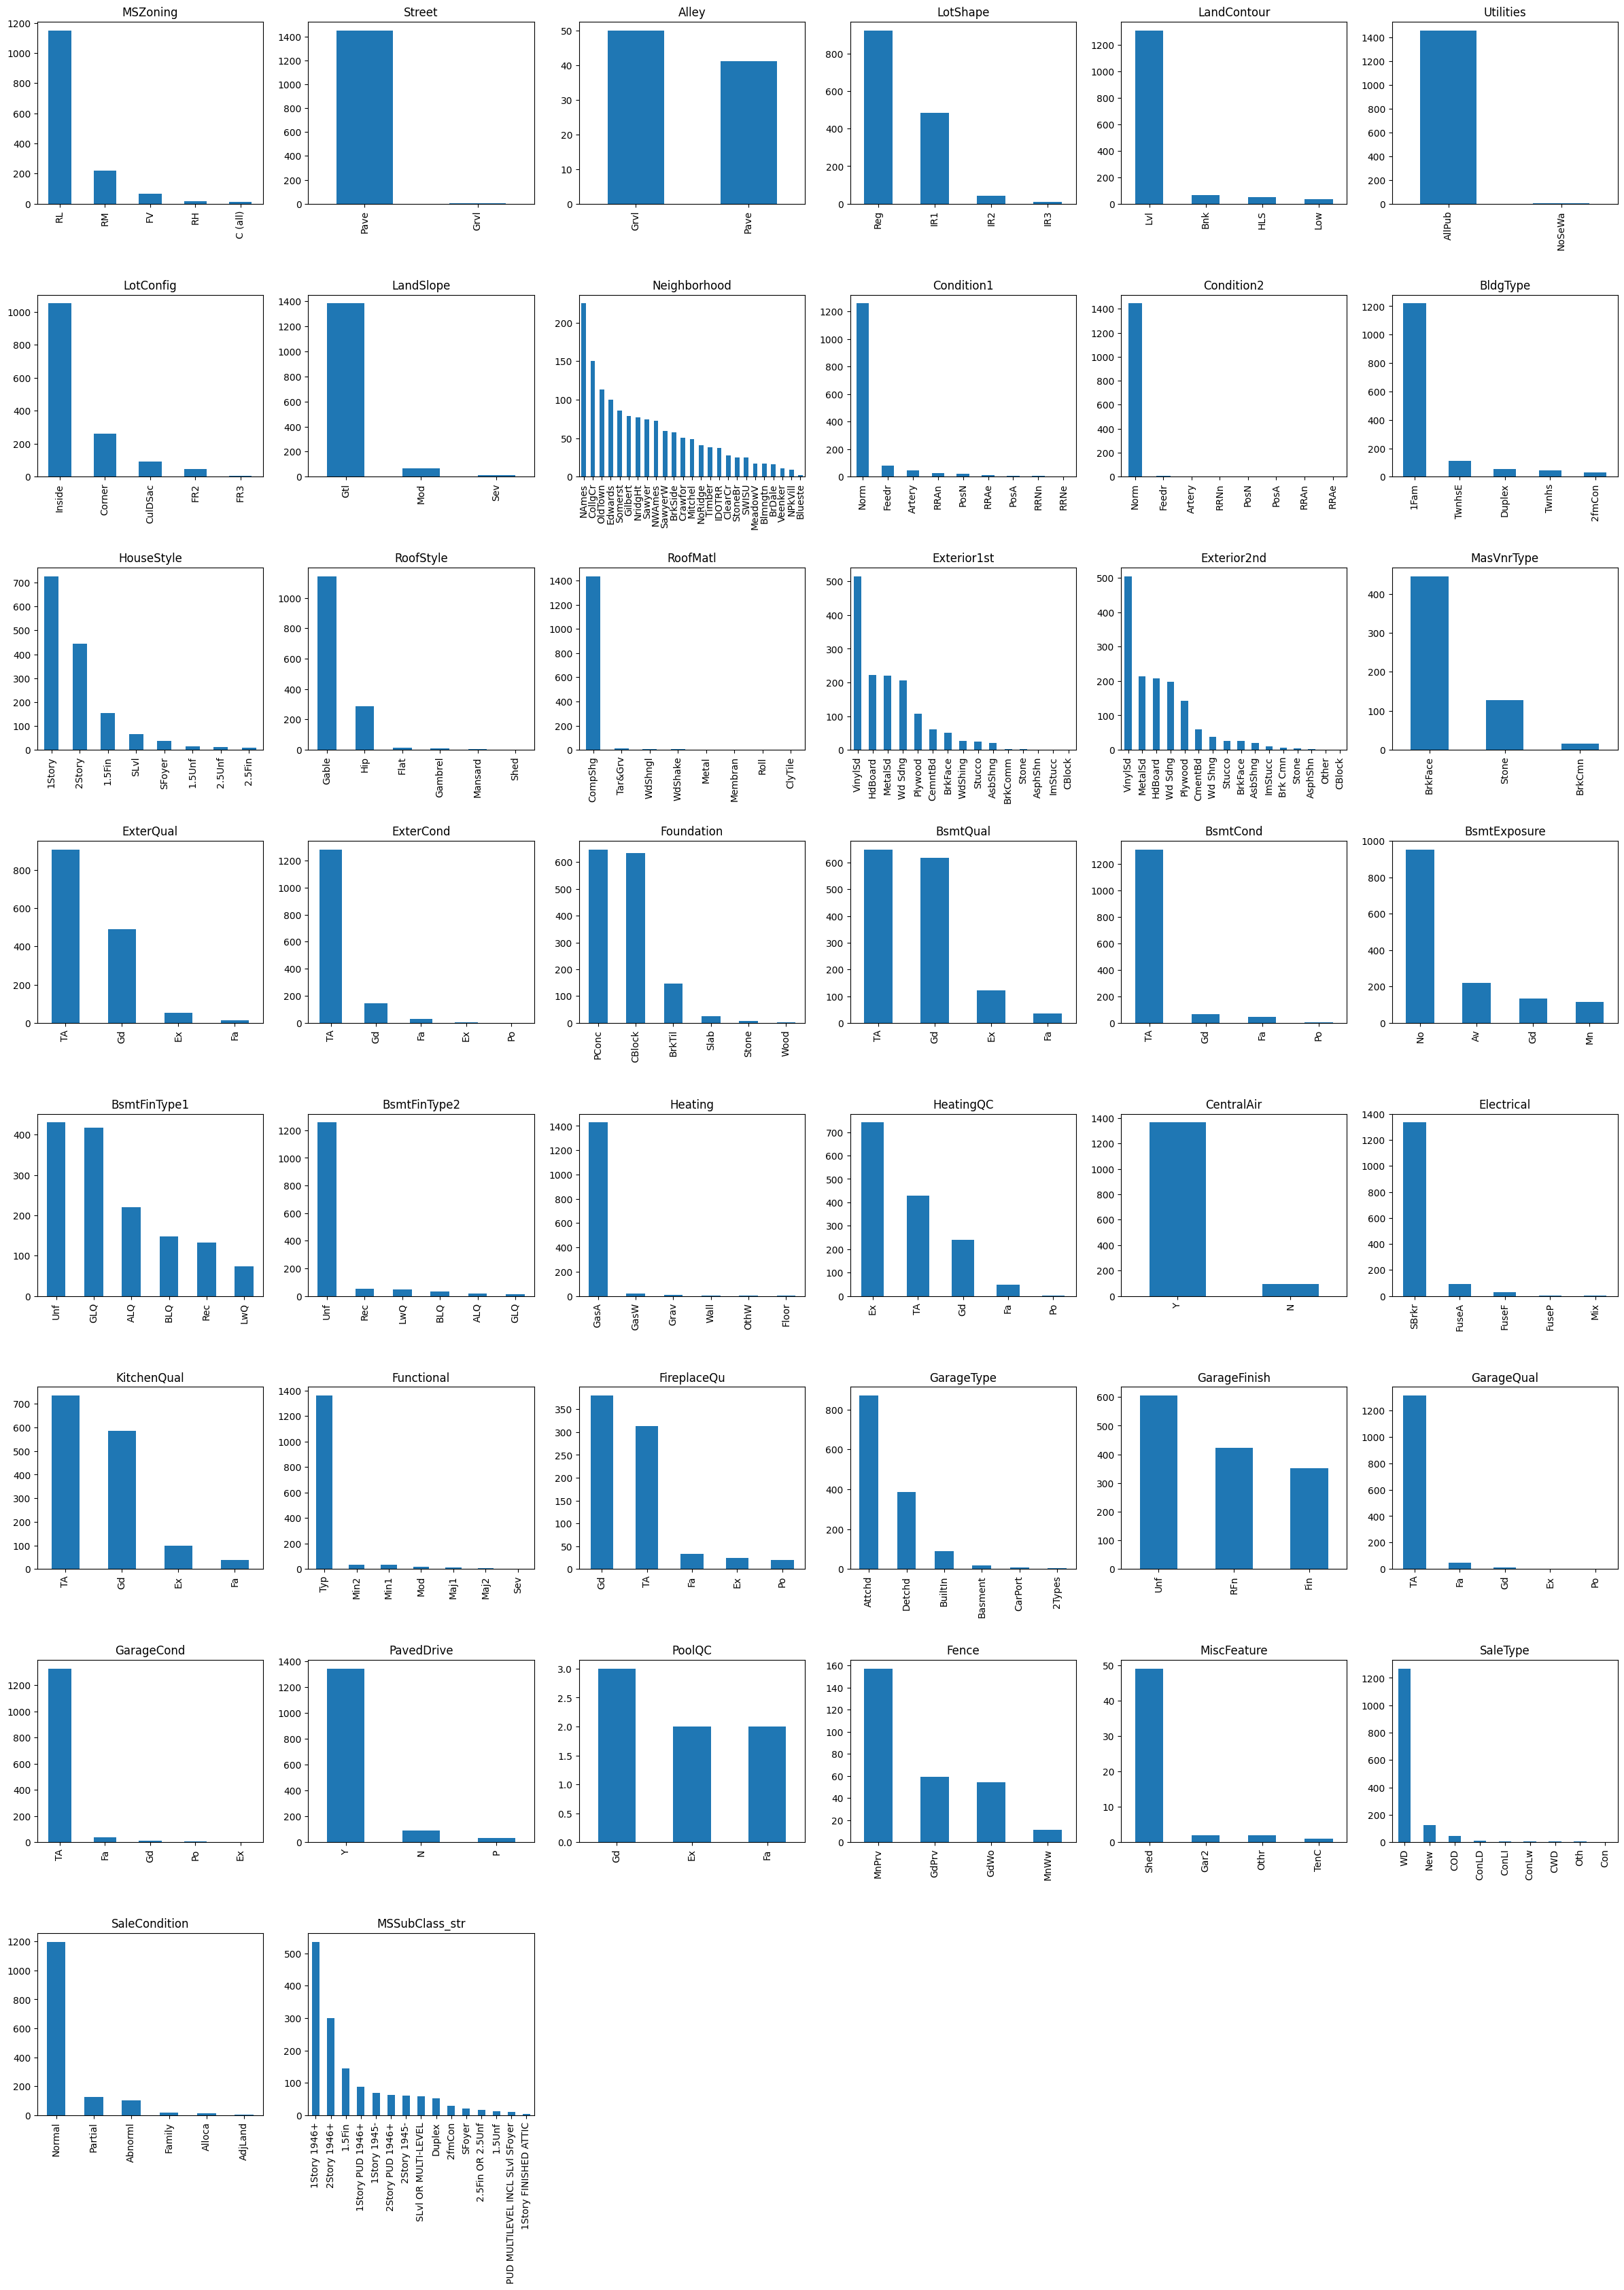

In [26]:
def plot_histograms_for_categoricals(df: pd.DataFrame, subplot_cols: int = 6) -> None:
    categorical_features = df.select_dtypes(include=["object"]).columns

    # calculate number of rows for subplots:
    feature_count = len(categorical_features)
    subplot_rows = (feature_count + subplot_cols - 1) // subplot_cols

    # create subplots:
    fig, axes = plt.subplots(
        nrows=subplot_rows,
        ncols=subplot_cols,
        figsize=(5 * subplot_cols, 5 * subplot_rows),
    )

    # adjust subplot spacing to avoid label overlap:
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

    # plot histograms for all categorical features in subplots:
    for i, feature in enumerate(categorical_features):
        row_index = i // subplot_cols
        col_index = i % subplot_cols
        ax = axes[row_index, col_index]
        X_train[feature].value_counts().plot(kind="bar", ax=ax)
        ax.set_title(feature)
        ax.set(xlabel=None)

    # remove any empty subplots:
    if feature_count % subplot_cols != 0:
        for j in range(feature_count % subplot_cols, subplot_cols):
            fig.delaxes(axes[subplot_rows - 1, j])

    plt.show()


# note: use data with handled missing data because it introduces new categories
plot_histograms_for_categoricals(df=X_train_no_nan)

Findings for the categorical features:
- The categorical features take between 2 and 25 distinct values.
- The features with more than 10 distinct values are Neighborhood, Exterior1st, Exterior2nd and MSSubClass (when converted to string). Those features (which have no order) will therefore produce a larger number of columns when being one-hot encoded.
- All categorical features are imbalanced. That is there are categories which are much less frequent than others. Rare categories may be difficult to generalize. One might consider grouping multiple rare categories into one feature "Other".

### Target

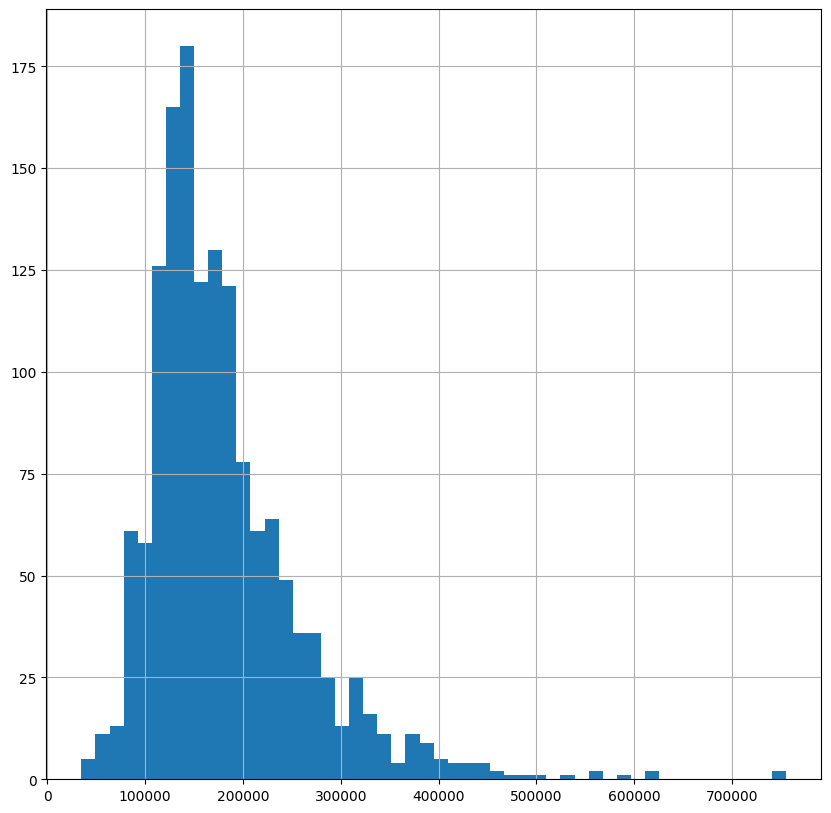

In [27]:
# histogram:
y_train.hist(figsize=(10, 10), bins=50)
plt.show()

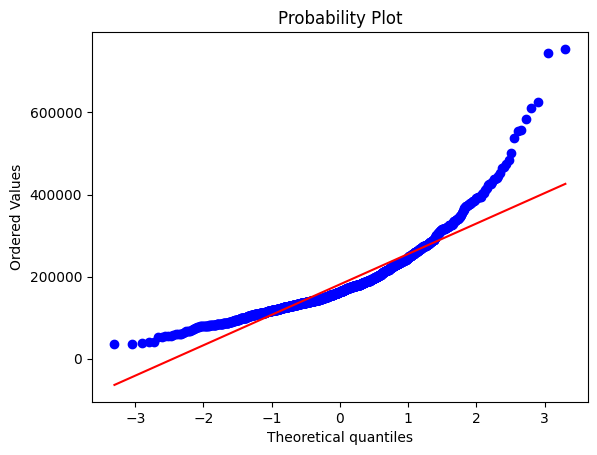

In [28]:
# quantile/quantile plot:
probplot(y_train, plot=plt)
plt.show()

In [29]:
skeweness = y_train.skew()
excess_kurtosis = y_train.kurt()
print(
    f"Skeweness: {skeweness} (normal distribution has 0)\nExcess kurtosis:"
    f" {excess_kurtosis} (normal distribution has 0)"
)

Skeweness: 1.8828757597682129 (normal distribution has 0)
Excess kurtosis: 6.536281860064529 (normal distribution has 0)


### Findings
- There are no infinite values in the training data.
- The numerical features differ greatly in their scale and are mostly far-off from normal distributions.
- The very frequent value 1950 in the feature YearRemodAff seems to be odd.
- All categorical features are imbalanced with some very rare categories.
- There are 4 (unordered) categorical features with more than 10 categories. 
- The target distribution is heavily positively skewed and highly leptokurtic. It has very few very high values.

## Relationship between features <a class="anchor"  id="featurerelation"></a>
**Questions: How the features related? Are there (multi)collinear features?**

### Numerical features
For numerical features, correlation metrics can be calculated. The Pearson correlation metric is used to measure linear relationships and thus, can indicate collinearity (for values near to the boundaries -1 or 1). To check also for non-linear relations, additionally the Kendall correlation is determined. It measures monotonic relationships and compared with the Spearman correlation, it has the advantages that it can handle ties and is less sensitive to outliers.

In [30]:
def analyze_correlations(df: pd.DataFrame, correlation_method: str = "pearson") -> None:
    # create custom color map:
    colors = [(0, "red"), (0.1, "orange"), (0.5, "white"), (0.9, "green"), (1, "blue")]
    cmap_custom = LinearSegmentedColormap.from_list("custom_colormap", colors)

    # plot correlation matrix:
    plt.figure(figsize=(12, 10))
    corr_matrix = df.corr(method=correlation_method)
    sns.heatmap(
        corr_matrix, square=True, vmin=-1, vmax=1, cmap=cmap_custom, linewidths=0.2
    )
    plt.show()

    # print maximal absolute correlation values:
    abs_max_corr = corr_matrix.apply(
        lambda col: abs(col).sort_values(ascending=False)[1], axis=0
    ).sort_values()
    # note: first element (self-correlation which is always maximal at 1.0) is ignored
    print(
        f"The maximum of the absolute value of the {correlation_method} correlation for"
        f" each feature:\n{abs_max_corr}"
    )

    # print min and max correlation:
    min_corr = corr_matrix.min().min()
    np.fill_diagonal(corr_matrix.values, -1)  # discard self-correlations
    max_corr = corr_matrix.values.max()
    print(
        f"Biggest {correlation_method} correlation: {max_corr}\nSmallest"
        f" {correlation_method} correlation: {min_corr}"
    )

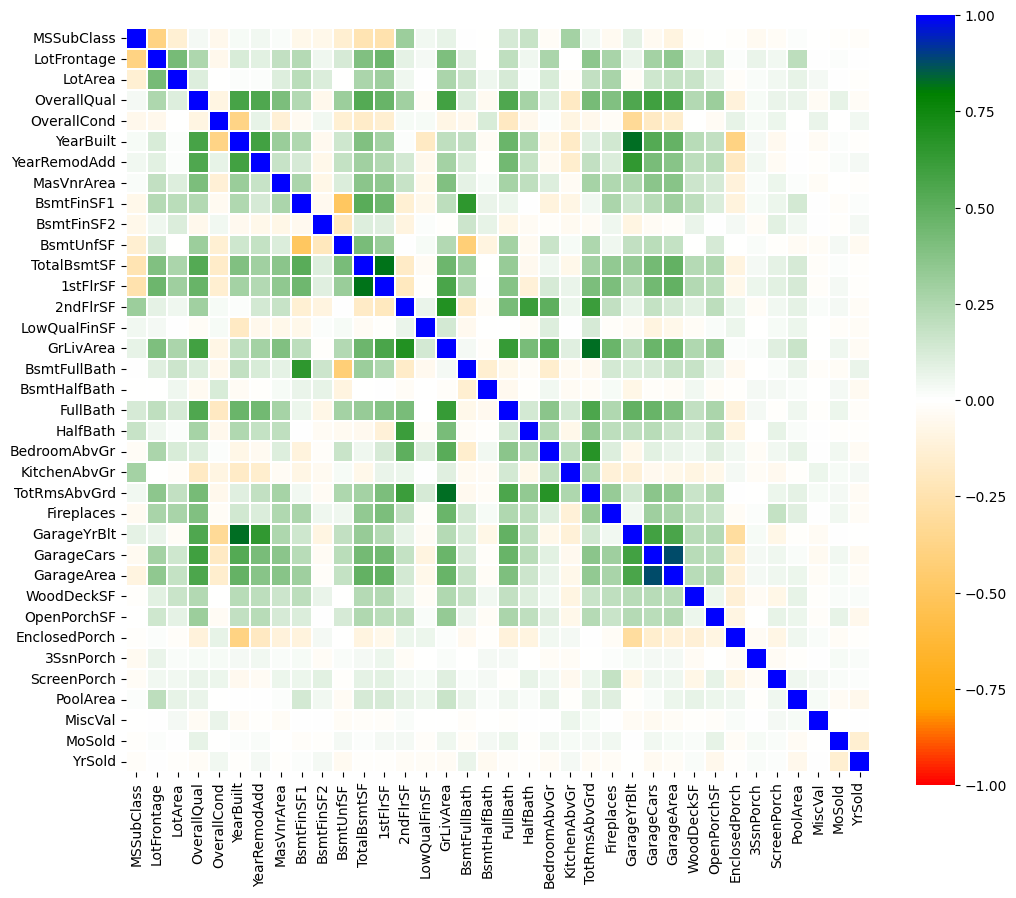

The maximum of the absolute value of the pearson correlation for each feature:
MiscVal          0.068777
3SsnPorch        0.070029
YrSold           0.145721
MoSold           0.145721
BsmtHalfBath     0.147871
LowQualFinSF     0.183784
ScreenPorch      0.184530
PoolArea         0.206167
BsmtFinSF2       0.209294
WoodDeckSF       0.247433
KitchenAbvGr     0.281721
OpenPorchSF      0.330224
OverallCond      0.375983
MSSubClass       0.386347
EnclosedPorch    0.387268
MasVnrArea       0.411876
LotArea          0.426095
LotFrontage      0.457181
Fireplaces       0.461679
BsmtUnfSF        0.495251
OverallQual      0.600671
HalfBath         0.609707
FullBath         0.630012
YearRemodAdd     0.642277
BsmtFinSF1       0.649212
BsmtFullBath     0.649212
BedroomAbvGr     0.676620
2ndFlrSF         0.687501
1stFlrSF         0.819530
TotalBsmtSF      0.819530
TotRmsAbvGrd     0.825489
GrLivArea        0.825489
GarageYrBlt      0.825667
YearBuilt        0.825667
GarageCars       0.882475
GarageArea 

In [31]:
# check linear relationships:
# note: use original data (without handled missing data) to avoid relationship distortion
analyze_correlations(df=X_train[num_cols], correlation_method="pearson")

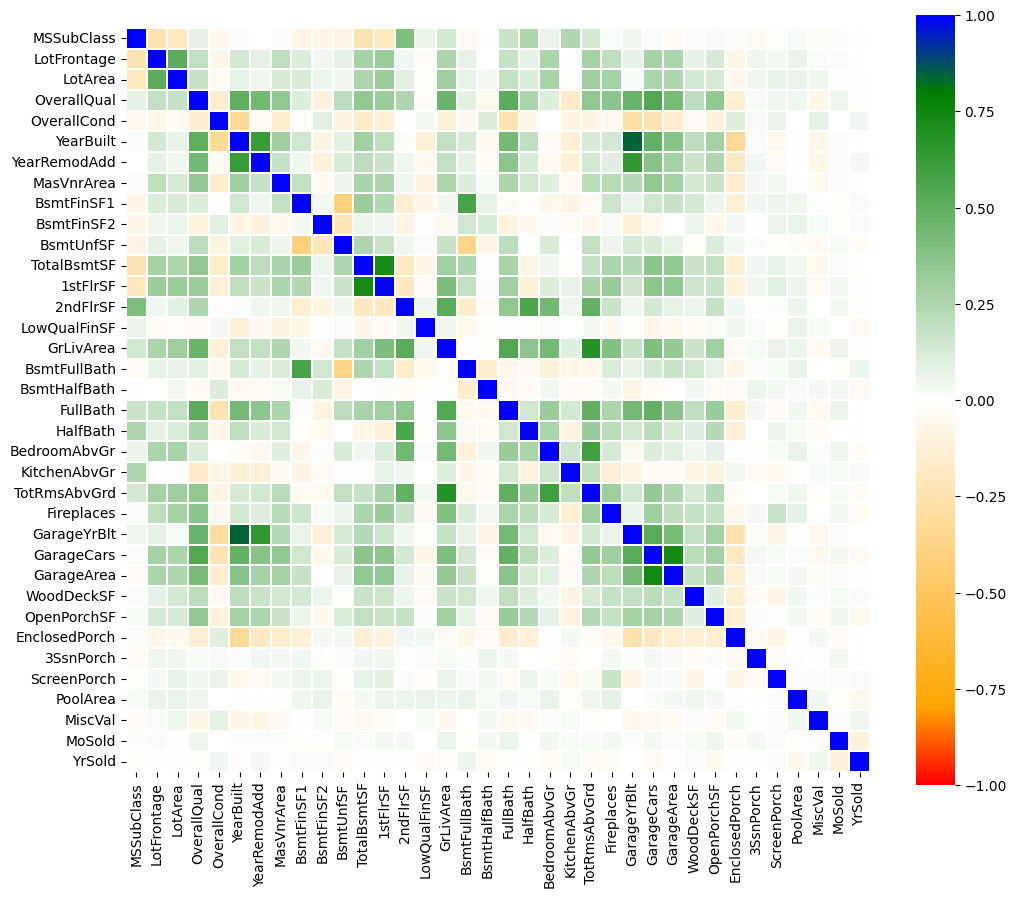

The maximum of the absolute value of the kendall correlation for each feature:
3SsnPorch        0.061251
MiscVal          0.079860
PoolArea         0.081113
YrSold           0.115970
MoSold           0.115970
LowQualFinSF     0.119523
BsmtHalfBath     0.149752
ScreenPorch      0.170317
WoodDeckSF       0.216431
BsmtFinSF2       0.217016
KitchenAbvGr     0.244957
EnclosedPorch    0.324028
OverallCond      0.329379
OpenPorchSF      0.346309
MasVnrArea       0.346929
Fireplaces       0.384239
MSSubClass       0.405345
BsmtUnfSF        0.412606
LotFrontage      0.510666
LotArea          0.510666
FullBath         0.539408
OverallQual      0.543120
2ndFlrSF         0.559822
HalfBath         0.559822
BsmtFullBath     0.573172
BsmtFinSF1       0.573172
BedroomAbvGr     0.596077
YearRemodAdd     0.644826
GrLivArea        0.684159
TotRmsAbvGrd     0.684159
1stFlrSF         0.731962
TotalBsmtSF      0.731962
GarageArea       0.736283
GarageCars       0.736283
YearBuilt        0.838521
GarageYrBlt

In [32]:
# check monotonic relationships:
analyze_correlations(df=X_train[num_cols], correlation_method="kendall")

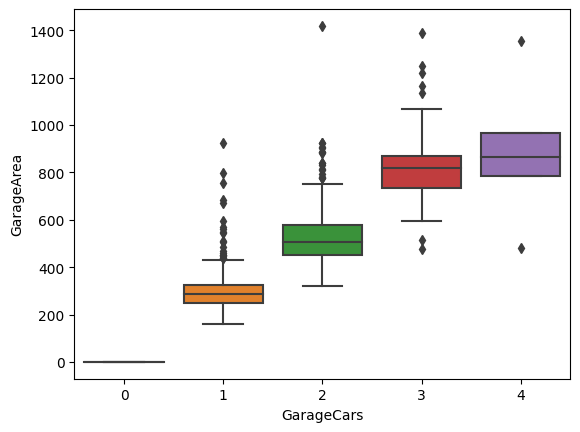

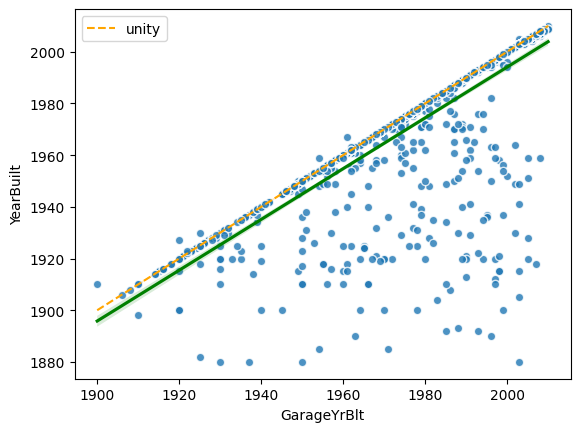

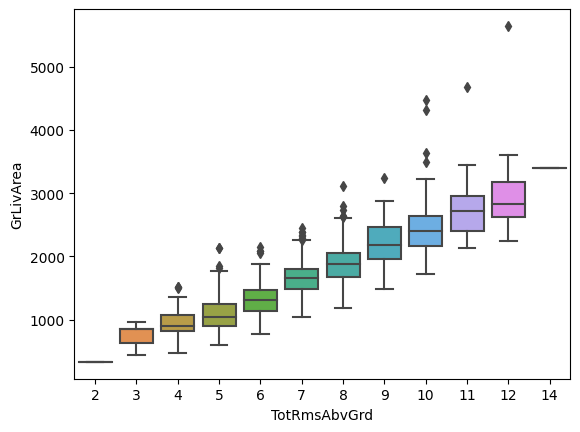

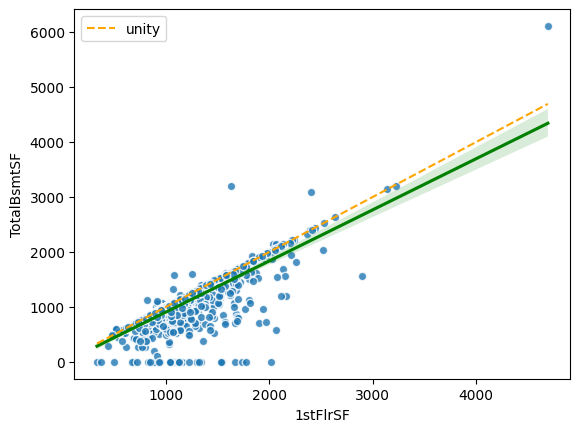

In [33]:
# plot relationship of highly correlated features:
# note: scatterplot for continuous features and boxplot if one feature is discrete
def plot_relationship(
    x,
    y,
    x_is_discrete: bool = False,
    x_is_categorical: bool = False,
    with_unity_line: bool = False,
):
    if x_is_discrete:
        sns.boxplot(x=x, y=y)
        # sns.regplot(x=x, y=y, line_kws=dict(color="green"), scatter=True) # there seems to be a bug for the alignment
    elif x_is_categorical:
        df = pd.DataFrame({"cat_x": x, "y": y})
        median_values = df.groupby("cat_x")["y"].median().reset_index()
        sorted_categories = median_values.sort_values(by="y")["cat_x"]
        sns.boxplot(x=x, y=y, order=sorted_categories)
        plt.xticks(rotation=90)
    else:
        sns.regplot(
            x=x, y=y, line_kws=dict(color="green"), scatter_kws={"edgecolor": "white"}
        )
    if with_unity_line:
        sns.lineplot(x=x, y=x, label="unity", linestyle="--", color="orange")
        plt.legend(loc="upper left")
    plt.show()


plot_relationship(x=X_train["GarageCars"], y=X_train["GarageArea"], x_is_discrete=True)
plot_relationship(
    x=X_train["GarageYrBlt"], y=X_train["YearBuilt"], with_unity_line=True
)
plot_relationship(x=X_train["TotRmsAbvGrd"], y=X_train["GrLivArea"], x_is_discrete=True)
plot_relationship(x=X_train["1stFlrSF"], y=X_train["TotalBsmtSF"], with_unity_line=True)

Findings for the numerical features:
- In general, positive correlations are more prominent than negative ones (for linear and non-linear relationships).
- MiscVal, 3SsnPorch, YrSold, MoSold, BsmtHalfBath, LowQualFinSF, ScreenPorch, PoolArea, BsmtFinSF2 have almost no (linear or non-linear) correlation with any other feature.
- Collinearity: Features with a particularly high linear relation (which might lead to problems like overfitting or unstable weights):
    - GarageCars & GarageArea
    - YearBuilt & GarageYrBlt
    - TotRmsAbvGrd & GrLivArea
    - 1stFlrSF & TotalBsmtSF
- The features with a high Kendall correlation coincide with the ones with a high Pearson correlation. This indicates that there is no strong monotonic relationship which severely deviates from a linear relation. However, YearBuilt and GarageYrBlt have a particular high Kendall correlation which suggests that the relationship is not purely linear.
- When plotting the highly related features, we see the following:
    - TotRmsAbvGrd & GrLivArea have a fairly linear relation.
    - GarageCars & GarageArea have a relation exerting a slight decrease in the slope with increasing GarageCars (however, it is hard to judge with that little distinct values for GarageCars). 
    - For YearBuilt & GarageYrBlt, a lot of the data points are on the unity line which means that the house and garage were built in the same year. However, there are also lots of houses where the garage has been built later. This relation is not really linear since the data is not randomly spread around a linear line but rather the unity line functions as an upper bound of the data (however this is not a strict upper bound since there are also a few houses which have been built after the garage).
    - TotRmsAbvGrd & GrLivArea are similar to YearBuilt & GarageYrBlt but besides the units line (which is less prominent here), there is also a zero line corresponding to houses with no basement at all.

### Categorical features
To check the dependence between 2 categorical variables, the (Pearson's) chi-squared test can be used. It uses the contingency table (which contains the observed value counts for the different pairs of values of the 2 variables) and the calculated expected value counts to determine a test statistic. Assuming the null hypothesis that the 2 variables are independent, this test statistic follows a chi-squared distribution and therefore is also referred to as chi-squared value. There are different chi-squared distribution depending on the number of degrees of freedom which can be obtained from the number of cells in the contingency table.

A high chi-squared value indicates that the 2 variables are dependent. In order to have a yes or no answer on the dependency, one can compare the calculated chi-squared value with a critical value that is obtained from the corresponding chi-squared distribution (for the given degrees of freedom) and a chosen confidence probability. If the absolute value of the test statistic is equal to or larger than the critical value, then one can conclude the 2 variables to be dependent with a certainty of the confidence probability.

Another way to jusdge whether the 2 variables are dependent, is to use the p-value of the chi-squared test. If the p-value if equal to or smaller than the significance level, then the 2 variables are said to be dependent. The significance level (often denoted by alpha) is defined to be 1 minus the confidence probability.

The chi-squared test is only valid if the test statistic really follows a chi-squared distribution under the null hypothesis. This is true for large sample sizes. Thus, in each cell of the contingency table, there should be at least 5 observations.
If this is not given, one can try to reduce the categories in the 2 variables. That is, one can combine the rarest categories into a new more frequent category.

Note: One can also use the Fisher's exact test for small sample sizes but it works only for 2x2 contingency tables (that is binary categories).

In [34]:
# run chi-squared test:
# note: use data with handled missing data to avoid "no data" error
confidence_probability = 0.95


def perform_chi2_test(
    variable1: pd.Series,
    variable2: pd.Series,
    reliable_count_threshold: int = 5,
    confidence_probability: Optional[float] = None,
) -> Tuple[Union[float, bool], bool]:
    contingency_table = pd.crosstab(variable1, variable2)  # observed counts
    chi_squared, pvalue, dof, expected_counts = chi2_contingency(
        observed=contingency_table
    )
    min_count = contingency_table.min().min()

    if min_count > reliable_count_threshold:
        test_is_reliable = True
    else:
        test_is_reliable = False

    if confidence_probability is None:
        # lower pvalue means that it is more likely that the variables are associated
        return pvalue, test_is_reliable
    else:
        critical_value = chi2.ppf(q=confidence_probability, df=dof)
        if abs(chi_squared) >= critical_value:
            # alternative condition: pvalues <= 1. - confidence_probabilty
            cols_are_dependent = True
        else:
            cols_are_dependent = False
        return cols_are_dependent, test_is_reliable


def check_all_dependences_with_chi2_test(
    df: pd.DataFrame,
    reliable_count_threshold: int = 5,
    confidence_probability: Optional[float] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    cols = df.columns
    reliability_df = pd.DataFrame(index=cols, columns=cols)
    dependence_df = pd.DataFrame(index=cols, columns=cols)
    for col1 in cols:
        for col2 in cols:
            cols_are_dependent, test_is_reliable = perform_chi2_test(
                variable1=df[col1],
                variable2=df[col2],
                reliable_count_threshold=reliable_count_threshold,
                confidence_probability=confidence_probability,
            )
            dependence_df.loc[col1, col2] = cols_are_dependent
            reliability_df.loc[col1, col2] = test_is_reliable

    return dependence_df, reliability_df


# note: include MSSubClass_str since this is actually a categorical column
dependence_df, reliability_df = check_all_dependences_with_chi2_test(
    df=X_train_no_nan[list(cat_cols) + ["MSSubClass_str"]],
    confidence_probability=confidence_probability,
)
reliable_percentage = reliability_df.mean().mean() * 100
print(
    f"{round(reliable_percentage, 2)}% of the chi-squared tests between the features"
    " are reliable because they have enough observations."
)

0.21% of the chi-squared tests between the features are reliable because they have enough observations.


90.55% of the chi-squared tests between the features are reliable because they have enough observations.
17 out of 44 categorical features have only one category left after the category reduction.


<Axes: >

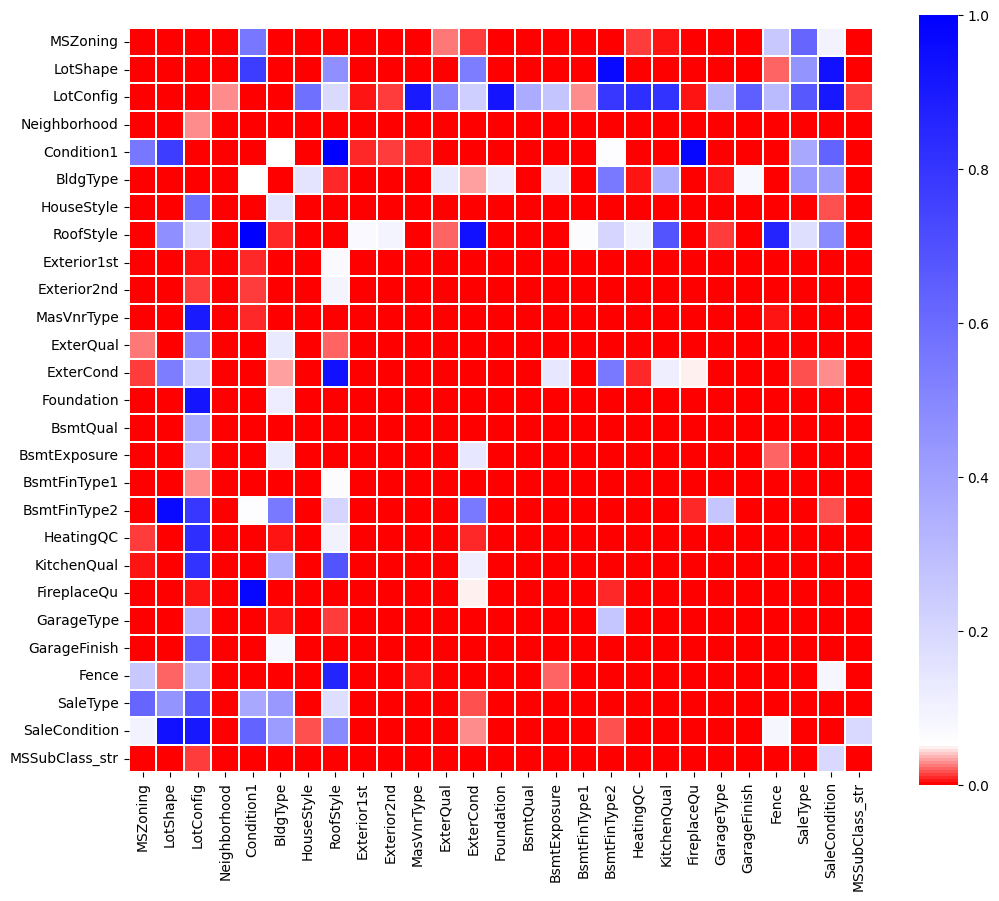

In [35]:
# run chi-squared test with reduces categories:
def reduce_categories(
    df: pd.DataFrame,
    categorical_column: str,
    min_entries_per_category: int = 100,
    new_category_name: str = "Rarest_Categories_Combined",
):
    category_counts = df[categorical_column].value_counts().sort_values(ascending=True)
    new_category_count = 0
    categories_to_combine = []
    for category in category_counts.index:
        categories_to_combine.append(category)
        new_category_count += category_counts[category]
        if new_category_count > min_entries_per_category:
            break
    df[categorical_column] = df[categorical_column].apply(
        lambda entry: new_category_name if entry in categories_to_combine else entry
    )

    return df


X_train_reduced_cat = X_train_no_nan[list(cat_cols) + ["MSSubClass_str"]].copy()
for col in cat_cols:
    X_train_reduced_cat = reduce_categories(
        X_train_reduced_cat, col, min_entries_per_category=150
    )

dependence_df, reliability_df = check_all_dependences_with_chi2_test(
    df=X_train_reduced_cat, confidence_probability=None
)

# check reliability of chi-squared test:
reliable_percentage = reliability_df.mean().mean() * 100
print(
    f"{round(reliable_percentage, 2)}% of the chi-squared tests between the features"
    " are reliable because they have enough observations."
)

# check how many features have only 1 category left after the category reduction:
red_cat_nunique = X_train_reduced_cat.nunique()
one_category_features = red_cat_nunique[red_cat_nunique == 1].sum()
print(
    f"{one_category_features} out of {len(X_train_reduced_cat.columns)} categorical"
    " features have only one category left after the category reduction."
)

# plot dependence between cat. features:
alpha = 1.0 - confidence_probability  # significance level
colors = [(0, "red"), (alpha, "white"), (1, "blue")]
cmap_custom = LinearSegmentedColormap.from_list("custom_colormap", colors)

reduced_nunique = X_train_reduced_cat.nunique()
# note: exclude columns with only 1 category which will naturally have no dependence
# with any other column
cols_with_more_than_one_cat = list(reduced_nunique[reduced_nunique > 1].index)
plt.figure(figsize=(12, 10))
sns.heatmap(
    dependence_df.loc[cols_with_more_than_one_cat, cols_with_more_than_one_cat].astype(
        float
    ),
    square=True,
    vmin=0.0,
    vmax=1.0,
    cmap=cmap_custom,
    linewidths=0.2,
)

Findings for the catrgorical features:
- Performing the chi-squared test for all feature pairs, I find only 0.21% of the results to be reliable. This is due to the fact that many categorical features have categories that are very rare or even do not occur at all. Therefore, rare categories are combined into one new category. I combine all categories with less than 150 occurrences since this seems to be a good trade-off between optimizing the reliability of the chi-squared tests and losing too many features with only one category left. This results in an overall reliability of 90.55% while 17 out of 44 features are lost.
- Using a confidence of 95%, there are a lot of significant dependencies (low p-value) among the categorical features. Neighbordhood, Exterior1st, Exterior2nd, BsmtFinType1 seem to be very likely related to all other (reduced) categories.
- Note that the p-value that is shown in the heatmap is not stating anything about the strength of the association but rather about the significance.

## Relationship with target <a class="anchor"  id="targetrelation"></a>
**Questions: Which features are most predictive? Is the relation of a feature with the target non-linear? Is a transformation of a feature helpful with your ML algorithm?**

## Outliers <a class="anchor"  id="outliers"></a>
**Questions: Are there outliers? Are those outliers misleading the prediction?**

## Clusters <a class="anchor"  id="clusters"></a>
**Questions: Are there clear clusters in the data that should be predicted separately?**